First 5 rows of the dataset:
         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8

Total samples: 3620
Training samples: 2896
Testing samples: 724

Total hyperparameter combinations: 128

Training model 1/128
Activation: tanh, Neurons: 50, Dropout: 0.2, Layers: 1, Optimizer: adam, Learning Rate: 0.001, Epochs: 20
Test Loss: 0.0075, MAE: 0.0678, MSE: 0.0075

Training model 2/128
Activation: tanh, Neurons: 50, Dropout: 0.2, Layers: 1, Optimizer: adam, Learning Rate: 0.001, Epochs: 30
Test Loss: 0.0071, MAE: 0.0663, MSE: 0.0071

Training model 3/128
Activation: tanh, Neurons: 50, Dropout: 0.2, Layers: 1, Optimizer: adam, Learning Rate: 0.01, Epochs: 20
Test Loss: 0.0072, MAE: 0.0669, MSE: 0.0072

Training model 4/128
Activation: tanh, Neurons: 50, Dropout: 0.2, Layers: 1, Optimizer: adam, Learning Rate: 0.01, Epochs: 30
Test Loss: 0.0072, MAE: 0.0665, MSE: 0.0072

Training model 5/128
Activation: tanh, Neurons: 50, Dropout

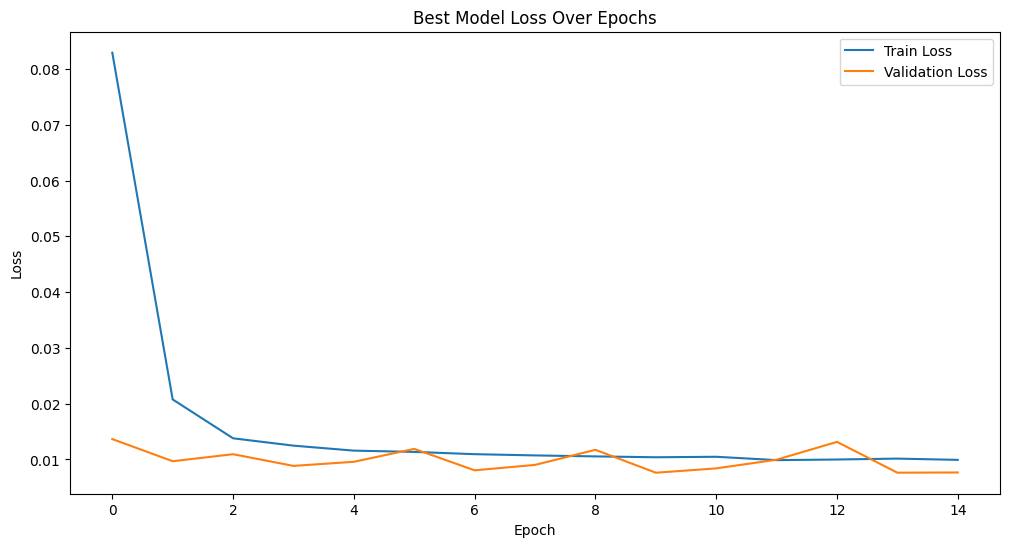


Best LSTM model saved as 'best_lstm_model.h5'.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
# **Hyperparameter Optimization for LSTM on Daily Minimum Temperatures Dataset**

# **Step 1: Import Necessary Libraries**

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
import csv
import os
import matplotlib.pyplot as plt

# Suppress TensorFlow warnings for cleaner output
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# **Step 2: Download the Dataset Directly from URL**

# Define the dataset URL
dataset_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

# Download the dataset using pandas
data = pd.read_csv(dataset_url)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# **Step 3: Load and Preprocess the Data**

def load_and_preprocess_data(data, sequence_length=30, test_size=0.2):
    """
    Preprocesses the dataset for LSTM modeling.

    Parameters:
        data (DataFrame): The raw dataset.
        sequence_length (int): Number of past days to use for prediction.
        test_size (float): Proportion of the dataset to include in the test split.

    Returns:
        X_train, X_test, y_train, y_test: Split and preprocessed data.
        scaler: Fitted MinMaxScaler object.
    """
    # Parse the 'Date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Check for missing values
    if data.isnull().values.any():
        print("Dataset contains missing values. Handling missing values...")
        data = data.dropna()

    # Feature Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Temp']])

    # Create sequences
    X = []
    y = []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    # Reshape X for LSTM [samples, timesteps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    print(f"\nTotal samples: {X.shape[0]}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    return X_train, X_test, y_train, y_test, scaler

# Preprocess the data
sequence_length = 30  # Using past 30 days to predict the next day
X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data(data, sequence_length, test_size=0.2)

# **Step 4: Define the LSTM Model Builder Function**

def build_model(num_layers, num_neurons, dropout_rate, activation, optimizer, learning_rate, input_shape):
    """
    Builds and compiles an LSTM model based on the provided hyperparameters.

    Parameters:
        num_layers (int): Number of LSTM layers.
        num_neurons (int): Number of neurons in each LSTM layer.
        dropout_rate (float): Dropout rate after each LSTM layer.
        activation (str): Activation function for LSTM layers.
        optimizer (str): Optimizer type ('adam', 'rmsprop', 'sgd').
        learning_rate (float): Learning rate for the optimizer.
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled Keras model.
    """
    model = Sequential()

    for i in range(num_layers):
        return_sequences = True if i < num_layers - 1 else False
        if i == 0:
            model.add(LSTM(units=num_neurons, activation=activation, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(LSTM(units=num_neurons, activation=activation, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Output layer for regression

    # Configure the optimizer with the learning rate
    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer type")

    # Compile the model
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

# **Step 5: Define the Hyperparameter Grid**

def get_hyperparameter_grid():
    """
    Defines the hyperparameter grid for optimization.

    Returns:
        List of hyperparameter combinations.
    """
    activation_functions = ['tanh', 'relu']
    num_neurons_options = [50, 100]
    dropout_rates = [0.2, 0.3]
    num_layers_options = [1, 2]
    optimizers = ['adam', 'rmsprop']
    learning_rates = [0.001, 0.01]
    epochs_options = [20, 30]

    hyperparameter_combinations = list(product(
        activation_functions,
        num_neurons_options,
        dropout_rates,
        num_layers_options,
        optimizers,
        learning_rates,
        epochs_options
    ))

    print(f"\nTotal hyperparameter combinations: {len(hyperparameter_combinations)}")
    return hyperparameter_combinations

# Define the hyperparameter grid
hyperparameter_combinations = get_hyperparameter_grid()

# **Step 6: Perform Hyperparameter Optimization**

def hyperparameter_optimization(X_train, X_test, y_train, y_test, hyperparameter_combinations, csv_file):
    """
    Iterates through hyperparameter combinations, trains and evaluates models, and records results.

    Parameters:
        X_train, X_test, y_train, y_test: Preprocessed data splits.
        hyperparameter_combinations (list): List of hyperparameter tuples.
        csv_file (str): Path to the CSV file to save results.
    """
    # Prepare CSV file
    header = [
        'Activation Function', 'Number of Neurons', 'Dropout Rate',
        'Number of Layers', 'Optimizer', 'Learning Rate', 'Epochs',
        'Test Loss', 'MAE', 'MSE'
    ]

    # Write header if file does not exist
    if not os.path.exists(csv_file):
        with open(csv_file, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)

    input_shape = (X_train.shape[1], X_train.shape[2])

    # Iterate through hyperparameter combinations
    for idx, (activation, neurons, dropout, layers, optimizer, lr, epochs) in enumerate(hyperparameter_combinations):
        print(f"\nTraining model {idx+1}/{len(hyperparameter_combinations)}")
        print(f"Activation: {activation}, Neurons: {neurons}, Dropout: {dropout}, Layers: {layers}, Optimizer: {optimizer}, Learning Rate: {lr}, Epochs: {epochs}")

        # Build the model
        model = build_model(layers, neurons, dropout, activation, optimizer, lr, input_shape)

        # Early stopping to prevent overfitting
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=0  # Change to 1 for more detailed output
        )

        # Evaluate the model
        evaluation = model.evaluate(X_test, y_test, verbose=0)
        test_loss, mae, mse = evaluation

        print(f"Test Loss: {test_loss:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}")

        # Append results to CSV
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                activation, neurons, dropout, layers, optimizer, lr, epochs,
                test_loss, mae, mse
            ])

# Define the path for the results CSV
results_csv = 'hyperparameter_results.csv'

# Perform hyperparameter optimization
hyperparameter_optimization(X_train, X_test, y_train, y_test, hyperparameter_combinations, results_csv)

# **Step 7: Identify and Save the Best Hyperparameters**

def find_best_hyperparameters(csv_file, metric='MSE', ascending=True):
    """
    Finds and saves the best hyperparameter configuration based on the specified metric.

    Parameters:
        csv_file (str): Path to the CSV file containing results.
        metric (str): Metric to sort by ('Test Loss', 'MAE', 'MSE').
        ascending (bool): Sort order.
    """
    # Load the results
    results = pd.read_csv(csv_file)

    # Check if the metric exists
    if metric not in results.columns:
        print(f"Metric '{metric}' not found in the results.")
        return

    # Sort the results based on the specified metric
    best_results = results.sort_values(by=metric, ascending=ascending).reset_index(drop=True)

    print(f"\nTop 5 configurations based on {metric}:")
    print(best_results.head(5))

    # Save the best configuration
    best_configuration = best_results.iloc[0]
    best_configuration.to_frame().T.to_csv('best_hyperparameters.csv', index=False)
    print("\nBest hyperparameter configuration saved to 'best_hyperparameters.csv'.")

# Identify and save the best hyperparameters based on MSE
find_best_hyperparameters(results_csv, metric='MSE', ascending=True)

# **Step 8: Download the Results CSV Files**

# To download the CSV files to your local machine, uncomment the following lines.
# from google.colab import files
# files.download('hyperparameter_results.csv')
# files.download('best_hyperparameters.csv')

# **Step 9: Visualize Training and Validation Loss for the Best Model**

# Optional: Visualize the training history of the best model
def visualize_training_history(model, X_train, y_train, X_test, y_test, epochs, batch_size=32):
    """
    Trains the model and plots the training and validation loss.

    Parameters:
        model: Compiled Keras model.
        X_train, y_train: Training data.
        X_test, y_test: Testing data.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
    """
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Example: Visualize for the best model
# Load the best hyperparameters
best_config = pd.read_csv('best_hyperparameters.csv')

# Extract hyperparameters
best_activation = best_config['Activation Function'].values[0]
best_neurons = best_config['Number of Neurons'].values[0]
best_dropout = best_config['Dropout Rate'].values[0]
best_layers = best_config['Number of Layers'].values[0]
best_optimizer = best_config['Optimizer'].values[0]
best_lr = best_config['Learning Rate'].values[0]
best_epochs = int(best_config['Epochs'].values[0])

print("\nTraining the best model for visualization...")

# Build the best model
best_model = build_model(best_layers, best_neurons, best_dropout, best_activation, best_optimizer, best_lr, (X_train.shape[1], X_train.shape[2]))

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    epochs=best_epochs,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# **Step 10: Save the Best Model (Optional)**

# Save the best model for future use
best_model.save('best_lstm_model.h5')
print("\nBest LSTM model saved as 'best_lstm_model.h5'.")

# To download the model, uncomment the following lines.
# from google.colab import files
# files.download('best_lstm_model.h5')